# Sumário

1. [Modelo de canal de 4 km](#8km)
2. [Modelo de canal de 8 km](#4km)
3. [Modelo de canal de 12 km](12km)
4. [Tratamento de dados](#dados)
4. [Implementação de uma rede neural recorrente (RNN) com PyTorch](#rnn)
5. [Treinamento e avaliação da RNN](#trainingrnn)
6. [Treinamento e avaliação de MLP](#trainingmlp)
7. [Cálculo e comparação da BER para sinais equalizados](#ber)

# A nonlinear ANN equalizer with mini-batch gradient descent in 40Gbaud PAM-8 IM/DD system

Nesse notebook, será implementada uma simulação de um sistema ótpico de transmissão de recepção IM/DD para um sinal de 40Gbaud, com modulação de amplitude de 8 níveis.

Então será analisado o desempenho de redes neurais recorrentes e MLP para equalização não linear em sistemas de 4, 8 e 12 km:

In [ ]:
import numpy as np
import torch
import importlib
import matplotlib.pyplot as plt

from optic.torchUtils import slidingWindowDataSet, MLP
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, ConcatDataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray


from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel


from sklearn.model_selection import train_test_split

import os, sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
sys.path.append('../Utils')
import OpticFunctions as of

from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
import IPython.display as ipd





In [ ]:
# Caso a máquina possua GPU, ela será utilizada
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# semente de geração aleatória
np.random.seed(seed=123)

#Padronização das figuras
figsize(10, 3)

In [ ]:
# Parâmetros para geração de sinal
SpS = 2
Rs = 40*10**9
M = 8
dist = [4, 8, 12]

<a id="4km"></a>
## Para fibra de 4 km

In [ ]:
# Sinal transmitido
sinalTx4, symbTx4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M, num_symbs = 1e4)
of.PlotEyediagram(sinalTx4, SpS, 'SinalTx')

# Sinal recebido
sinal4 = of.SimulaCanalOptico(sinal = sinalTx4, SpS = SpS, Rs = Rs, dist_fibra = dist[0],)
of.PlotEyediagram(sinal4, SpS = SpS, label = 'Sinal Recebido - 4 km')

SymbTx antes da normalização:  [-1. -7. -3. ...  5.  5.  3.]


<a id="8km"></a>
## Para fibra de 8 km

In [ ]:
# Sinal transmitido
sinalTx8, symbTx8 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M, num_symbs = 1e4)
of.PlotEyediagram(sinalTx8, SpS, 'SinalTx')

# Sinal recebido
sinal8 = of.SimulaCanalOptico(sinal = sinalTx8, SpS = SpS, Rs = Rs, dist_fibra = dist[1],)
of.PlotEyediagram(sinal8, SpS = SpS, label = 'Sinal Recebido - 8 km')

SymbTx antes da normalização:  [-3. -1. -1. ... -1.  3.  5.]


<a id="12km"></a>
## Para fibra de 12 km

In [ ]:
# Sinal transmitido
sinalTx12, symbTx12 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M, num_symbs = 1e4)
of.PlotEyediagram(sinalTx12, SpS, 'SinalTx')

# Sinal recebido
sinal12 = of.SimulaCanalOptico(sinal = sinalTx12, SpS = SpS, Rs = Rs, dist_fibra = dist[2],)
of.PlotEyediagram(sinal12, SpS = SpS, label = 'Sinal Recebido - 12 km')

SymbTx antes da normalização:  [ 3. -3. -1. ...  7.  7.  3.]


<a id="12km"></a>
## Tratamento de dados

In [ ]:
Ntaps = 2
batch_size = 200
shuffle = True
shuffle_full = False

# Criação e combinação dos datasets
train_dataset4, test_dataset4, full_dataset4 = of.CriaDataSet(symbTx4, sinal4, SpS, Ntaps = Ntaps)
train_dataset8, test_dataset8, full_dataset8 = of.CriaDataSet(symbTx8, sinal8, SpS, Ntaps = Ntaps)
train_dataset12, test_dataset12, full_dataset12 = of.CriaDataSet(symbTx12, sinal12, SpS, Ntaps = Ntaps)

comb_train_ds = ConcatDataset([train_dataset4, train_dataset8, train_dataset12])
comb_test_ds = ConcatDataset([test_dataset4, test_dataset8, test_dataset12])

#Criação dos dataloaders
train_dataloader = DataLoader(comb_train_ds, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(comb_test_ds, batch_size=batch_size, shuffle=shuffle)

full_dataloader_4 = DataLoader(full_dataset4, batch_size=len(full_dataset4), shuffle=shuffle_full)
full_dataloader_8 = DataLoader(full_dataset8, batch_size =len(full_dataset8), shuffle = shuffle_full)
full_dataloader_12 = DataLoader(full_dataset12, batch_size =len(full_dataset12), shuffle = shuffle_full)


# Inspeção dos dados (Especificamente paracanal de 4 km)
for batch in full_dataloader_4:
    # Extrair as amostras do lote
    inputs, targets = batch

    # Verificar o formato das amostras
    print("Formato das entradas:", inputs.shape)
    print("Formato dos alvos:", targets.shape)

    # Parar a iteração após a primeira amostra (opcional)
    break

<a id="rnn"></a>
## Implementação de uma Rede Neural Recorrente (RNN) com PyTorch

Este código define uma classe `RNN` personalizada utilizando o módulo `nn.Module` do PyTorch. A rede é composta por uma camada RNN seguida por uma camada totalmente conectada (linear). Abaixo está uma explicação detalhada de cada parte:

### Parâmetros do modelo
- `input_size`: número de características na entrada em cada etapa de tempo.
- `hidden_size`: número de unidades na camada oculta da RNN.
- `output_size`: número de neurônios na camada de saída (por exemplo, número de classes ou valores de regressão).
- `num_layers`: número de camadas recorrentes empilhadas.

### Estrutura da rede
- `self.rnn`: define a camada RNN com os parâmetros fornecidos. O argumento `batch_first=True` indica que o formato da entrada será `(batch_size, seq_length, input_size)`.
- `self.fc`: camada linear que transforma a saída da RNN para o tamanho desejado da saída.

### Método `forward`
- `h0`: inicializa o estado oculto com zeros. A forma correta seria `(num_layers, batch_size, hidden_size)`, mas aqui está como `(num_layers, hidden_size)`, o que pode causar erro dependendo da entrada. Certifique-se de ajustar isso conforme necessário.
- `out, h_n = self.rnn(x, h0)`: passa os dados pela RNN. `out` contém as saídas em todas as etapas de tempo, e `h_n` é o estado oculto final.
- `out = self.fc(out)`: aplica a camada linear à saída da RNN. Isso é feito em cada etapa de tempo.

In [ ]:
#------------------------------------------------------
# Definição da classe RNN
#------------------------------------------------------

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
        # Passar os dados pela RNN
        out, h_n = self.rnn(x, h0)  # h_n é o estado oculto final da última etapa de tempo

        # Passar a saída da RNN pela camada linear
        out = self.fc(out)
        return out


In [ ]:
# Parâmetros dos modelos RNN
input_size = Ntaps
hidden_size = 100
output_size = input_size//SpS
num_layers = 2

# Definição do modelo
#- Inicializada
#- Parâmetros salvos

modelo_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)
modelo_rnn2 = RNN(input_size, hidden_size, output_size, 4).to(device)
#modelo_rnn = torch.load('modelos/model_RNN.pth')
#modelo_rnn2 = torch.load('modelos/model_RNN2.pth')


<a id="trainingrnn"></a>
## Treinamento e Avaliação da RNN com PyTorch

Nesta seção, definimos os métodos para treinar e avaliar o desempenho de uma Rede Neural Recorrente (RNN) utilizando PyTorch. A abordagem é voltada para tarefas de regressão, como indicado pelo uso da função de perda `MSELoss`.

### Configuração do Treinamento
- `loss_fn = nn.MSELoss()`: define a função de perda como o erro quadrático médio (MSE), ideal para problemas de regressão.
- `optimizer_rnn` e `optimizer_rnn2`: otimizadores do tipo Adam para os modelos `modelo_rnn` e `modelo_rnn2`, com taxa de aprendizado de `0.007`.
- `epochs_rnn = 40`: número de épocas para o treinamento.
- `cada_print = 5000`: frequência com que a perda será exibida durante o treinamento (a cada 5000 batches).

### Função `train_loop_rnn`
Esta função realiza o treinamento do modelo em um conjunto de dados:

- `model.train()`: coloca o modelo em modo de treinamento.
- Para cada batch:
  - Os dados são convertidos para `float` e movidos para o dispositivo (CPU/GPU).
  - O modelo realiza uma previsão (`predict = model(x)`).
  - A perda é calculada entre a previsão e o valor real (`loss_value = loss(predict, y)`).
  - O gradiente é calculado e os pesos são atualizados (`loss_value.backward()`, `optimizer.step()`).
  - Os gradientes são zerados para evitar acumulação (`optimizer.zero_grad()`).
- A cada `cada_print` batches, a perda atual é exibida no console.

### Função `test_loop_rnn`
Esta função avalia o modelo em um conjunto de dados de validação/teste:

- `equalizer.eval()`: coloca o modelo em modo de avaliação.
- `torch.no_grad()`: desativa o cálculo de gradientes para economizar memória e acelerar a execução.
- Para cada batch:
  - Os dados são processados e a previsão é feita.
  - A perda é acumulada.
- Ao final, a perda média é calculada e exibida.

---

Essas funções são essenciais para monitorar o desempenho do modelo durante o treinamento e garantir que ele esteja aprendendo de forma adequada. Se desejar, podemos adicionar métricas adicionais ou salvar checkpoints do modelo.

In [ ]:
# Parâmetros e otimizadores para treinamento
loss_fn = nn.MSELoss()
epochs_rnn = 50
cada_print = 5000

optimizer_rnn = torch.optim.Adam(modelo_rnn.parameters(), lr = 0.007)
optimizer_rnn2 = torch.optim.Adam(modelo_rnn2.parameters(), lr = 0.007)


In [ ]:
#------------------------------------------------------
# Treinamento e Validação das RNN (use para inicializadas)
#------------------------------------------------------
for t in range(epochs_rnn):
    print(f"Época {t+1}\n-------------------------------")

    of.train_loop_rnn(train_dataloader, modelo_rnn, loss_fn, optimizer_rnn, cada_print)
    of.test_loop_rnn(test_dataloader, modelo_rnn, loss_fn)

    of.train_loop_rnn(train_dataloader, modelo_rnn2, loss_fn, optimizer_rnn2, cada_print)
    of.test_loop_rnn(test_dataloader, modelo_rnn2, loss_fn)
    
print("Pronto!")

# Salvamento das redes treinadas
torch.save(modelo_rnn, 'modelos/model_RNN.pth')
torch.save(modelo_rnn2, 'modelos/model_RNN2.pth')

Época 1
-------------------------------
loss: 0.238097[  200/24000]
Perda média: 0.267638 

Época 2
-------------------------------
loss: 0.242391[  200/24000]
Perda média: 0.274183 

Época 3
-------------------------------
loss: 0.231233[  200/24000]
Perda média: 0.257822 

Época 4
-------------------------------
loss: 0.203323[  200/24000]
Perda média: 0.268916 

Época 5
-------------------------------
loss: 0.231735[  200/24000]
Perda média: 0.274928 

Época 6
-------------------------------
loss: 0.217723[  200/24000]
Perda média: 0.245629 

Época 7
-------------------------------
loss: 0.259369[  200/24000]
Perda média: 0.252388 

Época 8
-------------------------------
loss: 0.233950[  200/24000]
Perda média: 0.253006 

Época 9
-------------------------------
loss: 0.241707[  200/24000]
Perda média: 0.248164 

Época 10
-------------------------------
loss: 0.249704[  200/24000]
Perda média: 0.259062 

Época 11
-------------------------------
loss: 0.291471[  200/24000]
Perda médi

<a id="trainingmlp"></a>
# Treinamento e avaliação de MLP

In [ ]:
epochs_mlp = epochs_rnn

# Definição do modelo
# - Inicializada
# - Parâmetros salvos
modelo_mlp = MLP([Ntaps, 10, 1])
modelo_mlp2 = MLP([Ntaps, 20, 10, 1])

#modelo_mlp = torch.load('modelos/model_MLP.pth')
#modelo_mlp2 = torch.load('modelos/model_MLP2.pth')

optimizer_mlp = torch.optim.Adam(modelo_mlp.parameters(), lr = 0.005)
optimizer_mlp2 = torch.optim.Adam(modelo_mlp2.parameters(), lr = 0.005)

In [ ]:
#------------------------------------------------------
# Treinamento e validação (Use para rede inicializada)
#------------------------------------------------------


for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")

    of.train_loop(train_dataloader, modelo_mlp, loss_fn, optimizer_mlp, cada_print)
    of.test_loop(test_dataloader, modelo_mlp, loss_fn)

    of.train_loop(train_dataloader, modelo_mlp2, loss_fn, optimizer_mlp2, cada_print)
    of.test_loop(test_dataloader, modelo_mlp2, loss_fn)

print("Pronto!")


# Salvando rede treinada
torch.save(modelo_mlp, 'modelos/model_MLP.pth')
torch.save(modelo_mlp2, 'modelos/model_MLP2.pth')

#------------------------------------------------------
# Teste para rede de 4 km
#------------------------------------------------------
'''
symb_mlp = of.GeraSinalEqualizado(modelo_mlp2, full_dataloader_4)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
bitsRxMlp = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbTx4), M, 'pam')

of.CalculaBER(bitt, bitsRxMlp)

symb_mlp = of.GeraSinalEqualizado(modelo_mlp, full_dataloader_4)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
bitsRxMlp = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbTx4), M, 'pam')

of.CalculaBER(bitt, bitsRxMlp)
'''

<a id="ber"></a>
## Cálculo e comparação da BER para os sinais equalizados por cada rede

In [ ]:
discard = 100
distance = np.arange(4, 12)

BER = np.zeros(distance.size)
BER_RNN = np.zeros(distance.size)
BER_RNN2 = np.zeros(distance.size)
BER_MLP = np.zeros(distance.size)
BER_MLP2 = np.zeros(distance.size)

power = -2
Ntaps = 2
const = GrayMapping(M, 'pam') 
Es = signal_power(const)

sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = power, num_symbs = 1e5)

for ind, dist in enumerate(distance):
    
    # Dados do canal
    irx = of.SimulaCanalOptico(sinaltx, SpS = SpS, Rs = Rs, dist_fibra = dist)
    treino_dataset, teste_dataset, dataset = of.CriaDataSet(symbtx, irx, SpS, Ntaps = Ntaps)
    dataloader = DataLoader(dataset, batch_size =len(dataset), shuffle = False)
    
    
    # Taxa de erro de bit para sinal não equalizado
    bitstx = of.RecuperaBits(sinaltx, SpS, M)
    bitsrx = of.RecuperaBits(irx, SpS, M)
    err = np.logical_xor(bitsrx[discard:bitsrx.size-discard], bitstx[discard:bitstx.size-discard])
    BER[ind] = np.mean(err)
    print('BER = %.2e '%(BER[ind]))
    
    #-----------------------------------------------
    # Equalização
    #-----------------------------------------------

    #RNN com 2 camadas
    symb_RNN = of.RetornaSinalEqualizado_RNN(modelo_rnn, dataloader)
    bits_RNN = demodulateGray(np.sqrt(Es)*pnorm(symb_RNN), M, 'pam')

    
    err = np.logical_xor(bits_RNN[discard:bits_RNN.size-discard], bitstx[discard:bitstx.size-discard])
    BER_RNN[ind] = np.mean(err)

    
    print('BER_RNN = %.2e '%(BER_RNN[ind]))
    
    #RNN com 4 camadas
    symb_RNN2 = of.RetornaSinalEqualizado_RNN(modelo_rnn2, dataloader)
    bits_RNN2 = demodulateGray(np.sqrt(Es)*pnorm(symb_RNN2), M, 'pam')
    
    err = np.logical_xor(bits_RNN2[discard:bits_RNN2.size-discard], bitstx[discard:bitstx.size-discard])
    BER_RNN2[ind] = np.mean(err)

    
    print('BER_RNN2 = %.2e '%(BER_RNN2[ind]))
    
    #MLP com 3 camadas
    symb_MLP = of.GeraSinalEqualizado(modelo_mlp, dataloader)
    bits_MLP = demodulateGray(np.sqrt(Es)*pnorm(symb_MLP), M, 'pam')
    
    err = np.logical_xor(bits_MLP[discard:bits_MLP.size-discard], bitstx[discard:bitstx.size-discard])
    BER_MLP[ind] = np.mean(err)

    
    print('BER_MLP = %.2e '%(BER_MLP[ind]))
    
    #MLP com 4 camadas
    symb_MLP2 = of.GeraSinalEqualizado(modelo_mlp2, dataloader)
    bits_MLP2 = demodulateGray(np.sqrt(Es)*pnorm(symb_MLP2), M, 'pam')
    
    err = np.logical_xor(bits_MLP2[discard:bits_MLP2.size-discard], bitstx[discard:bitstx.size-discard])
    BER_MLP2[ind] = np.mean(err)

    
    print('BER_MLP2 = %.2e '%(BER_MLP2[ind]))
    
    

SymbTx antes da normalização:  [ 7.  7. -3. ... -5. -3.  1.]
BER = 2.04e-01 
BER_RNN = 1.26e-01 
BER_RNN2 = 1.34e-01 
BER_MLP = 9.07e-02 
BER_MLP2 = 9.94e-02 
BER = 2.35e-01 
BER_RNN = 1.40e-01 
BER_RNN2 = 1.46e-01 
BER_MLP = 1.15e-01 
BER_MLP2 = 1.23e-01 
BER = 2.68e-01 
BER_RNN = 1.71e-01 
BER_RNN2 = 1.70e-01 
BER_MLP = 1.47e-01 
BER_MLP2 = 1.56e-01 
BER = 3.04e-01 
BER_RNN = 2.22e-01 
BER_RNN2 = 2.04e-01 
BER_MLP = 1.89e-01 
BER_MLP2 = 1.96e-01 
BER = 3.45e-01 
BER_RNN = 2.72e-01 
BER_RNN2 = 2.50e-01 
BER_MLP = 2.39e-01 
BER_MLP2 = 2.46e-01 
BER = 3.73e-01 
BER_RNN = 3.13e-01 
BER_RNN2 = 2.90e-01 
BER_MLP = 2.86e-01 
BER_MLP2 = 2.92e-01 
BER = 3.88e-01 
BER_RNN = 3.42e-01 
BER_RNN2 = 3.22e-01 
BER_MLP = 3.22e-01 
BER_MLP2 = 3.26e-01 
BER = 3.96e-01 
BER_RNN = 3.65e-01 
BER_RNN2 = 3.49e-01 
BER_MLP = 3.49e-01 
BER_MLP2 = 3.53e-01 


Text(0, 0.5, 'log10(BER)')

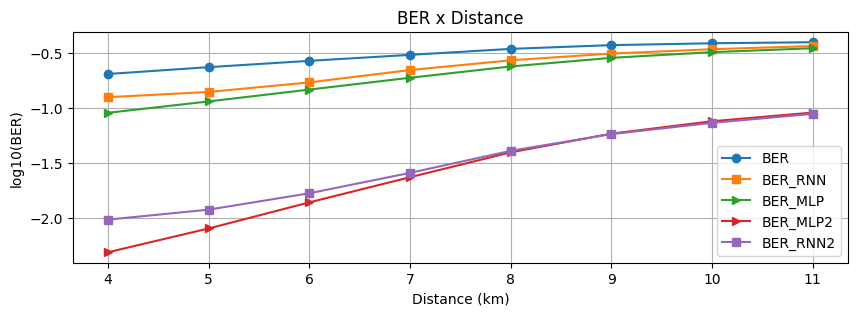

In [108]:
plt.plot(distance, np.log10(BER),'-o', label='BER')
plt.plot(distance, np.log10(BER_RNN),'-s', label='BER_RNN')
plt.plot(distance, np.log10(BER_MLP), '>-', label = 'BER_MLP')
plt.plot(distance, np.log(BER_MLP2), '>-', label = 'BER_MLP2')
plt.plot(distance, np.log(BER_RNN2), '-s',label = "BER_RNN2")
plt.grid()
plt.legend();
plt.title('BER x Distance')
plt.xlabel('Distance (km)')
plt.ylabel('log10(BER)')